# [2020 DACON GA 데이터 - Private 1위](https://dacon.io/competitions/official/235683/codeshare/2341?page=1&dtype=recent&ptype=pub) 

미래의 사용자 행동 패턴 예측 

In [24]:
import pandas as pd 
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

# 한글 깨짐 해결 
from matplotlib import rc
rc('font', family='NanumMyeongjo')
plt.rcParams['axes.unicode_minus'] = False

In [114]:
train1 = pd.read_csv('2020DACON_GA/1차_open_data/train.csv', encoding = 'cp949')
train2 = pd.read_csv('2020DACON_GA/2차_open_data/2차_train.csv', encoding = 'cp949')

train = pd.concat([train1, train2], axis = 0)
submission =pd.read_csv('2020DACON_GA/1차_open_data/submission.csv', encoding = 'cp949')

In [5]:
train.head(3)

,DateTime,사용자,세션,신규방문자,페이지뷰
0,2018-09-09 00:00:00,19,19,8,206
1,2018-09-09 01:00:00,20,19,9,259
2,2018-09-09 02:00:00,12,9,1,48


In [6]:
info_comp = pd.read_csv('2020DACON_GA/2차_추가데이터/new_competition_info.csv', encoding= 'cp949')
info_login = pd.read_csv('2020DACON_GA/2차_추가데이터/new_login_info.csv', encoding= 'cp949')
info_user = pd.read_csv('2020DACON_GA/2차_추가데이터/new_user_info.csv', encoding= 'cp949')
info_sub = pd.read_csv('2020DACON_GA/2차_추가데이터/new_submission_info.csv', encoding= 'cp949')

In [11]:
print(info_comp.shape, info_login.shape, info_user.shape, info_sub.shape)

(52, 17) (164121, 6) (25011, 10) (113635, 6)


In [115]:
# train 데이터 일별로 summary 
train['DateTime'] =pd.to_datetime(train['DateTime'])
train['date'] = train['DateTime'].dt.date

train = train.groupby('date').sum().reset_index()
train.tail()

,date,사용자,세션,신규방문자,페이지뷰
817,2020-12-04,3189,3068,743,75730
818,2020-12-05,2055,2019,497,47638
819,2020-12-06,2119,2077,460,46914
820,2020-12-07,2979,2988,753,77443
821,2020-12-08,3033,2990,772,68857


Text(0.5, 0, '날짜')

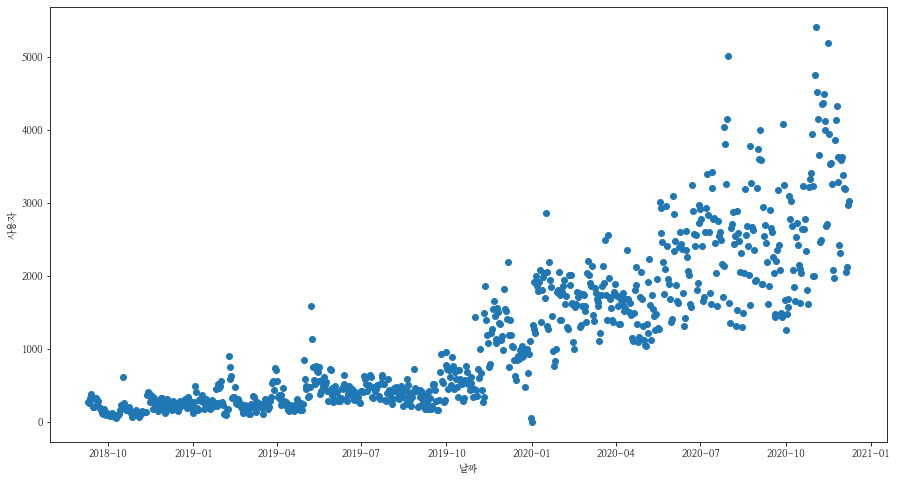

In [25]:
plt.figure(figsize = (15, 8))
plt.scatter(x = train['date'], y =train['사용자'])
plt.ylabel('사용자')
plt.xlabel('날짜')

### Feature Extraction 

In [59]:
comp = info_comp.dropna(how = 'all')
login = info_login.dropna(how = 'all')
user = info_user.dropna(how = 'all')
sub = info_sub.dropna(how ='all')

In [35]:
print(info_comp.shape, info_login.shape, info_user.shape, info_sub.shape)
print(comp.shape, login.shape, user.shape, sub.shape)

(52, 17) (164121, 6) (25011, 10) (113635, 6)
(51, 17) (161408, 6) (24606, 10) (110272, 6)


In [36]:
comp['period_start'] = pd.to_datetime(comp['period_start'])
comp['period_end'] = pd.to_datetime(comp['period_end'])
comp['start_date'] = comp['period_start'].dt.date
comp['end_date'] = comp['period_end'].dt.date

In [37]:
start_comp_fe = comp.groupby('start_date').count().reset_index()[['start_date', 'cpt_id']]

In [40]:
start_comp_fe.columns = ['date','start_comp_count']

In [77]:
start_comp_fe.head(3)

,date,start_comp_count
0,2018-08-14,1
1,2018-09-15,1
2,2018-10-18,1


In [41]:
end_comp_fe = comp.groupby('end_date').count().reset_index()[['end_date','cpt_id']]
end_comp_fe.columns = ['date','end_comp_count']

In [47]:
# login 데이터 일별로 summary 
login.head(3)

,Unnamed: 0,login_id,user_id,c_time,platform,browser
0,0.0,14196.0,14446.0,2018-09-23 1:30,Windows 8,Internet Explorer 10.0
1,1.0,14234.0,7287.0,2018-09-23 2:46,Windows,Chrome 67.0.3396.99
2,2.0,14256.0,7356.0,2018-09-23 3:35,Windows,Chrome 69.0.3497.100


In [60]:
login['c_time'] = pd.to_datetime(login['c_time'])
login['date'] = login['c_time'].dt.date
login.head(2)

,Unnamed: 0,login_id,user_id,c_time,platform,browser,date
0,0.0,14196.0,14446.0,2018-09-23 01:30:00,Windows 8,Internet Explorer 10.0,2018-09-23
1,1.0,14234.0,7287.0,2018-09-23 02:46:00,Windows,Chrome 67.0.3396.99,2018-09-23


In [67]:
login_fe = login.groupby('date').nunique().drop(['date','Unnamed: 0', 'c_time'], axis =1).reset_index()
login_fe.columns = ['date','login_count','login_user','login_platform','login_browser']

login_fe.head() # 날자별 총 로그인 수, 접속 사용자수, 사용 플랫폼 수, 사용자 브라우저수 

,date,login_count,login_user,login_platform,login_browser
0,2018-09-23,35,18,6,11
1,2018-09-24,30,21,5,12
2,2018-09-25,18,14,2,6
3,2018-09-26,48,29,5,10
4,2018-09-27,31,23,3,9


In [68]:
# User 데이터 일별로 Summary 
user.head(3)

,Unnamed: 0,id,c_time,entered_competition_cnt,code_share_cnt,talk_board_cnt,country_code,python_level,ds_level,sms_auth_date
0,0.0,5158.0,2017-05-02 23:58,98.0,321.0,503.0,82.0,1.0,1.0,NaN
1,1.0,14446.0,2018-08-08 18:21,1.0,0.0,0.0,82.0,1.0,1.0,NaN
2,2.0,13978.0,2018-08-08 19:57,1.0,0.0,0.0,82.0,1.0,1.0,NaN


In [69]:
user['c_time'] = pd.to_datetime(user['c_time'])
user['date']=user['c_time'].dt.date

In [70]:
user_fe = user.groupby('date').count()['id'].reset_index()
user_fe.columns = ['date','user_count']
user_fe.head(3)

,date,user_count
0,2017-05-02,1
1,2018-08-08,6
2,2018-08-09,1


In [71]:
# Submission 데이터 일별 Summary 
sub.head(3)

,Unnamed: 0,sub_id,cpt_id,team_id,user_id,c_time
0,0.0,-250918.0,229255.0,5019.0,23529.0,2019-11-24 20:40
1,1.0,-250904.0,229611.0,5162.0,16668.0,2019-11-24 20:36
2,2.0,-250881.0,235401.0,5042.0,7048.0,2019-11-24 20:24


In [72]:
sub['c_time'] = pd.to_datetime(sub['c_time'])
sub['date'] = sub['c_time'].dt.date

In [74]:
sub_fe = sub.groupby('date').nunique().drop(['Unnamed: 0','c_time','date'], axis = 1 ).reset_index()
sub_fe.columns = ['date','sub_count','sub_cpt','sub_team','sub_user']
sub_fe.head(3)

,date,sub_count,sub_cpt,sub_team,sub_user
0,2018-08-14,2,1,2,2
1,2018-08-15,1,1,1,1
2,2018-08-16,1,1,1,1


In [89]:
train_X =  pd.merge(train, start_comp_fe, on ='date', how ='left' )
train_X =  pd.merge(train_X, end_comp_fe, on ='date',how ='left')
train_X =  pd.merge(train_X, login_fe, on ='date',how ='left')
train_X =  pd.merge(train_X, user_fe, on ='date', how='left')
train_X =  pd.merge(train_X, sub_fe, on ='date',how ='left')

train_X.head()

,date,사용자,세션,신규방문자,페이지뷰,start_comp_count,end_comp_count,login_count,login_user,login_platform,login_browser,user_count,sub_count,sub_cpt,sub_team,sub_user
0,2018-09-09,281,266,73,1826,NaN,NaN,NaN,NaN,NaN,NaN,9.0,71.0,1.0,18.0,18.0
1,2018-09-10,264,247,51,2092,NaN,NaN,NaN,NaN,NaN,NaN,4.0,74.0,1.0,21.0,21.0
2,2018-09-11,329,310,58,1998,NaN,NaN,NaN,NaN,NaN,NaN,6.0,94.0,1.0,22.0,22.0
3,2018-09-12,300,287,45,2595,NaN,NaN,NaN,NaN,NaN,NaN,2.0,93.0,1.0,21.0,21.0
4,2018-09-13,378,344,50,3845,NaN,1.0,NaN,NaN,NaN,NaN,7.0,94.0,1.0,26.0,26.0


In [90]:
train_X['weekday'] = pd.to_datetime(train['date']).dt.weekday # 요일 
train_X['holiday'] = [1 if (x == 5) | (x == 6) else 0 for x in train_X['weekday']] # 주말 여부 

train_X.fillna(0, inplace =True)

In [91]:
train_X.head(3)

,date,사용자,세션,신규방문자,페이지뷰,start_comp_count,end_comp_count,login_count,login_user,login_platform,login_browser,user_count,sub_count,sub_cpt,sub_team,sub_user,weekday,holiday
0,2018-09-09,281,266,73,1826,0.0,0.0,0.0,0.0,0.0,0.0,9.0,71.0,1.0,18.0,18.0,6,1
1,2018-09-10,264,247,51,2092,0.0,0.0,0.0,0.0,0.0,0.0,4.0,74.0,1.0,21.0,21.0,0,0
2,2018-09-11,329,310,58,1998,0.0,0.0,0.0,0.0,0.0,0.0,6.0,94.0,1.0,22.0,22.0,1,0


In [97]:
# test features  생성 

submission['DateTime'] = submission['DateTime'].astype(str)
start_comp_fe['date'] = start_comp_fe['date'].astype(str)
end_comp_fe['date'] = end_comp_fe['date'].astype(str)
login_fe['date'] = login_fe['date'].astype(str)
user_fe['date'] =user_fe['date'].astype(str)
sub_fe['date']=sub_fe['date'].astype(str)

In [98]:
temp_sub = submission[['DateTime']]
temp_sub.columns =['date']

In [100]:
test_X =  pd.merge(temp_sub, start_comp_fe, on ='date', how ='left' )
test_X =  pd.merge(test_X, end_comp_fe, on ='date',how ='left')
test_X =  pd.merge(test_X, login_fe, on ='date',how ='left')
test_X =  pd.merge(test_X, user_fe, on='date',how ='left')
test_X =  pd.merge(test_X, sub_fe, on ='date',how ='left')

test_X.head()

,date,start_comp_count,end_comp_count,login_count,login_user,login_platform,login_browser,user_count,sub_count,sub_cpt,sub_team,sub_user
0,2020-11-09,NaN,NaN,460,397,0,0,162,511,20,224,212
1,2020-11-10,NaN,NaN,356,315,0,0,75,504,13,218,213
2,2020-11-11,2.0,NaN,504,398,0,0,86,587,15,247,237
3,2020-11-12,NaN,NaN,394,332,0,0,61,571,17,251,245
4,2020-11-13,NaN,2.0,397,332,0,0,74,609,18,263,265


In [101]:
test_X['weekday'] = pd.to_datetime(test_X['date']).dt.weekday # 요일 
test_X['holiday'] = [1 if (x == 5) | (x == 6) else 0 for x in test_X['weekday']] # 주말 여부 

test_X.fillna(0, inplace =True)

In [102]:
test_X.head(3)

,date,start_comp_count,end_comp_count,login_count,login_user,login_platform,login_browser,user_count,sub_count,sub_cpt,sub_team,sub_user,weekday,holiday
0,2020-11-09,0.0,0.0,460,397,0,0,162,511,20,224,212,0,0
1,2020-11-10,0.0,0.0,356,315,0,0,75,504,13,218,213,1,0
2,2020-11-11,2.0,0.0,504,398,0,0,86,587,15,247,237,2,0


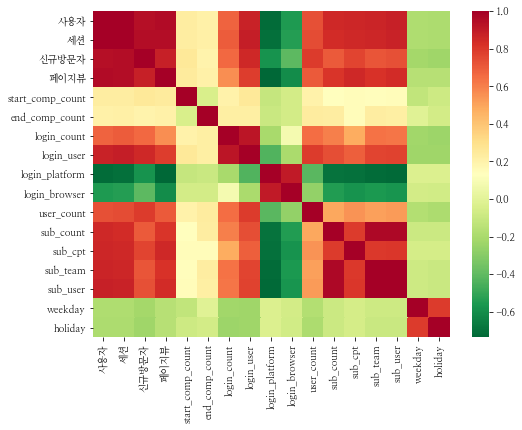

In [103]:
plt.figure(figsize = (8,6))
sns.heatmap(train_X.corr(), cmap ='RdYlGn_r')

## Model

In [104]:
train_X.head(3)

,date,사용자,세션,신규방문자,페이지뷰,start_comp_count,end_comp_count,login_count,login_user,login_platform,login_browser,user_count,sub_count,sub_cpt,sub_team,sub_user,weekday,holiday
0,2018-09-09,281,266,73,1826,0.0,0.0,0.0,0.0,0.0,0.0,9.0,71.0,1.0,18.0,18.0,6,1
1,2018-09-10,264,247,51,2092,0.0,0.0,0.0,0.0,0.0,0.0,4.0,74.0,1.0,21.0,21.0,0,0
2,2018-09-11,329,310,58,1998,0.0,0.0,0.0,0.0,0.0,0.0,6.0,94.0,1.0,22.0,22.0,1,0


In [105]:
test_X.head(3)

,date,start_comp_count,end_comp_count,login_count,login_user,login_platform,login_browser,user_count,sub_count,sub_cpt,sub_team,sub_user,weekday,holiday
0,2020-11-09,0.0,0.0,460,397,0,0,162,511,20,224,212,0,0
1,2020-11-10,0.0,0.0,356,315,0,0,75,504,13,218,213,1,0
2,2020-11-11,2.0,0.0,504,398,0,0,86,587,15,247,237,2,0


In [106]:
y_user = train_X.iloc[:,1]
y_session = train_X.iloc[:,2]
y_visit = train_X.iloc[:,3]
y_view = train_X.iloc[:,4]

X_train = train_X.iloc[:,5:]
X_test = test_X.iloc[:,1:]

In [107]:
# 최소 최대 정규화 

ms = MinMaxScaler()
X_train_m = pd.DataFrame(ms.fit_transform(X_train))
X_test_m = pd.DataFrame(ms.fit_transform(X_test))

In [108]:
# 개별 모델 성능 RMSE 확인 

knn_model = KNeighborsRegressor()
svr_model = SVR()
lr_model = LinearRegression()
rf_model = RandomForestRegressor()
lgb_model = LGBMRegressor()

In [109]:
# target feature : y_user
cross_score_knn  = cross_val_score(knn_model, X_train_m, y_user, scoring ='neg_mean_squared_error', cv= 5)
cross_score_svr  = cross_val_score(svr_model, X_train_m, y_user, scoring ='neg_mean_squared_error', cv= 5)
cross_score_lr   = cross_val_score(lr_model, X_train_m, y_user, scoring ='neg_mean_squared_error', cv= 5)
cross_score_rf   = cross_val_score(rf_model, X_train_m, y_user, scoring ='neg_mean_squared_error', cv= 5)
cross_score_lgb  = cross_val_score(lgb_model, X_train_m, y_user, scoring ='neg_mean_squared_error', cv= 5)

In [110]:
r_score_knn = np.sqrt(-cross_score_knn)
r_score_svr = np.sqrt(-cross_score_svr)
r_score_lr  = np.sqrt(-cross_score_lr)
r_score_rf  = np.sqrt(-cross_score_rf)
r_score_lgb = np.sqrt(-cross_score_lgb)

In [112]:
print('평균 KNN score : ', r_score_knn.mean() )
print('평균 SVR score : ', r_score_svr.mean() )
print('평균 LR score : ', r_score_lr.mean() )
print('평균 RF score : ', r_score_rf.mean() )
print('평균 LGB score : ', r_score_lgb.mean() )

평균 KNN score :  473.18405253623314
평균 SVR score :  1180.6038946405856
평균 LR score :  288.09685779866624
평균 RF score :  393.653088302494
평균 LGB score :  383.9061111458001


In [116]:
# 예측 

lr_model = LinearRegression()
lr_model.fit(X_train_m, y_user)
submission['사용자'] = lr_model.predict(X_test_m)
submission.head()

,DateTime,사용자,세션,신규방문자,페이지뷰
0,2020-11-09,3571.292775,0,0,0
1,2020-11-10,2594.016953,0,0,0
2,2020-11-11,3238.554211,0,0,0
3,2020-11-12,2991.393694,0,0,0
4,2020-11-13,3291.529790,0,0,0


In [117]:
lr_model = LinearRegression()
lr_model.fit(X_train_m, y_session)
submission['세션'] = lr_model.predict(X_test_m)
submission.head()

,DateTime,사용자,세션,신규방문자,페이지뷰
0,2020-11-09,3571.292775,3518.351652,0,0
1,2020-11-10,2594.016953,2494.544164,0,0
2,2020-11-11,3238.554211,3136.276001,0,0
3,2020-11-12,2991.393694,2853.369780,0,0
4,2020-11-13,3291.529790,3114.467847,0,0


In [118]:
lr_model = LinearRegression()
lr_model.fit(X_train_m, y_visit)
submission['신규방문자'] = lr_model.predict(X_test_m)
submission.head()

,DateTime,사용자,세션,신규방문자,페이지뷰
0,2020-11-09,3571.292775,3518.351652,913.648580,0
1,2020-11-10,2594.016953,2494.544164,527.389603,0
2,2020-11-11,3238.554211,3136.276001,711.214757,0
3,2020-11-12,2991.393694,2853.369780,570.728252,0
4,2020-11-13,3291.529790,3114.467847,621.430513,0


In [119]:
lr_model = LinearRegression()
lr_model.fit(X_train_m, y_view)
submission['페이지뷰'] = lr_model.predict(X_test_m)
submission.head()

,DateTime,사용자,세션,신규방문자,페이지뷰
0,2020-11-09,3571.292775,3518.351652,913.648580,93556.995705
1,2020-11-10,2594.016953,2494.544164,527.389603,65448.515422
2,2020-11-11,3238.554211,3136.276001,711.214757,83745.592427
3,2020-11-12,2991.393694,2853.369780,570.728252,74846.557964
4,2020-11-13,3291.529790,3114.467847,621.430513,95358.346757
